# Credit Risk Analysis using XGBoost

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_score
from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
%pip install -U scikit-learn 
%pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTE
import warnings
import pickle

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## 2. Data Loading and Inspection

In [2]:
df = pd.read_csv('new_german_credit_discrete.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)  # Drop unnecessary index column
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Most valuable available asset      1000 non-null   int64
 11  Age (years)                        1000 non-null   int64
 12  Concurrent Credits   

### Correlation Matrix

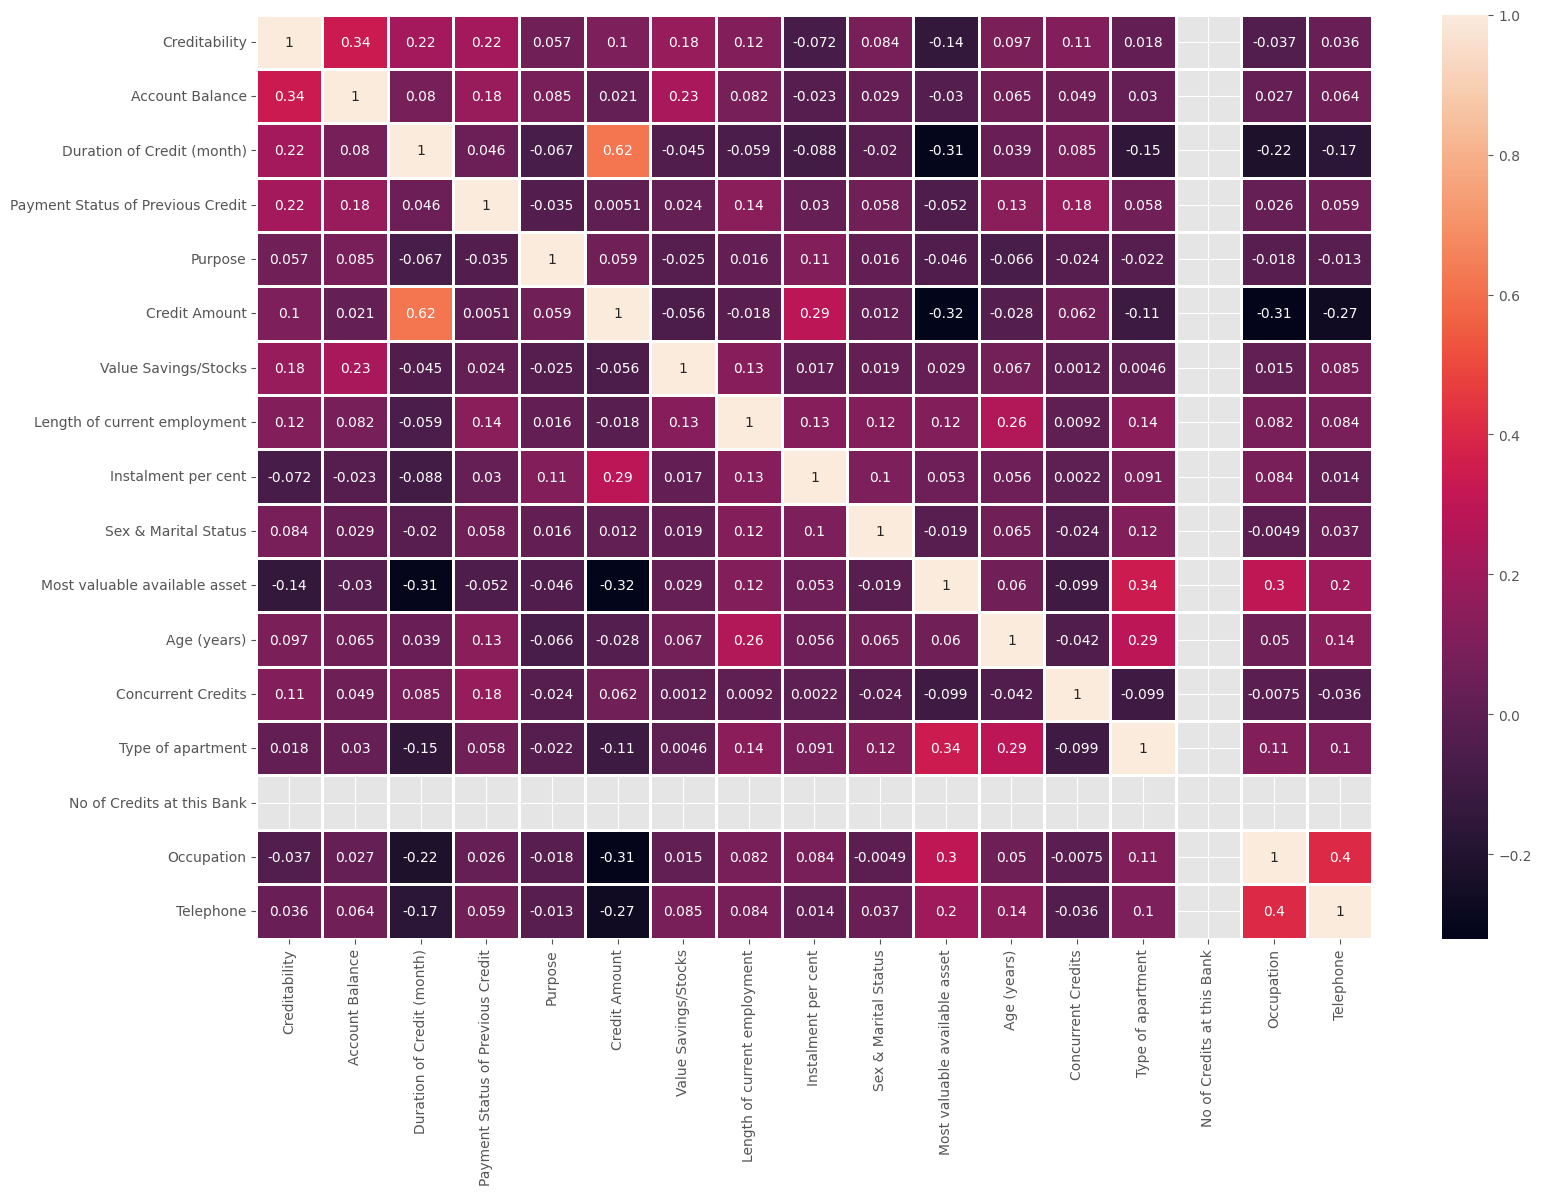

In [3]:
plt.figure(figsize=(18, 12))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.2g', linewidths=1)
plt.show()

## 3. Data Preprocessing

### Creating dependent and independent variables

In [6]:
X = df.drop(['Creditability'], axis=1)
y = df['Creditability']

### Encode categorical variables if needed

In [7]:
label_encoder = LabelEncoder()
for column in X.columns:
    if X[column].dtype == 'object':
        X[column] = label_encoder.fit_transform(X[column])

### Handling class imbalance using SMOTE

In [8]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

### Visualizing distributions of features

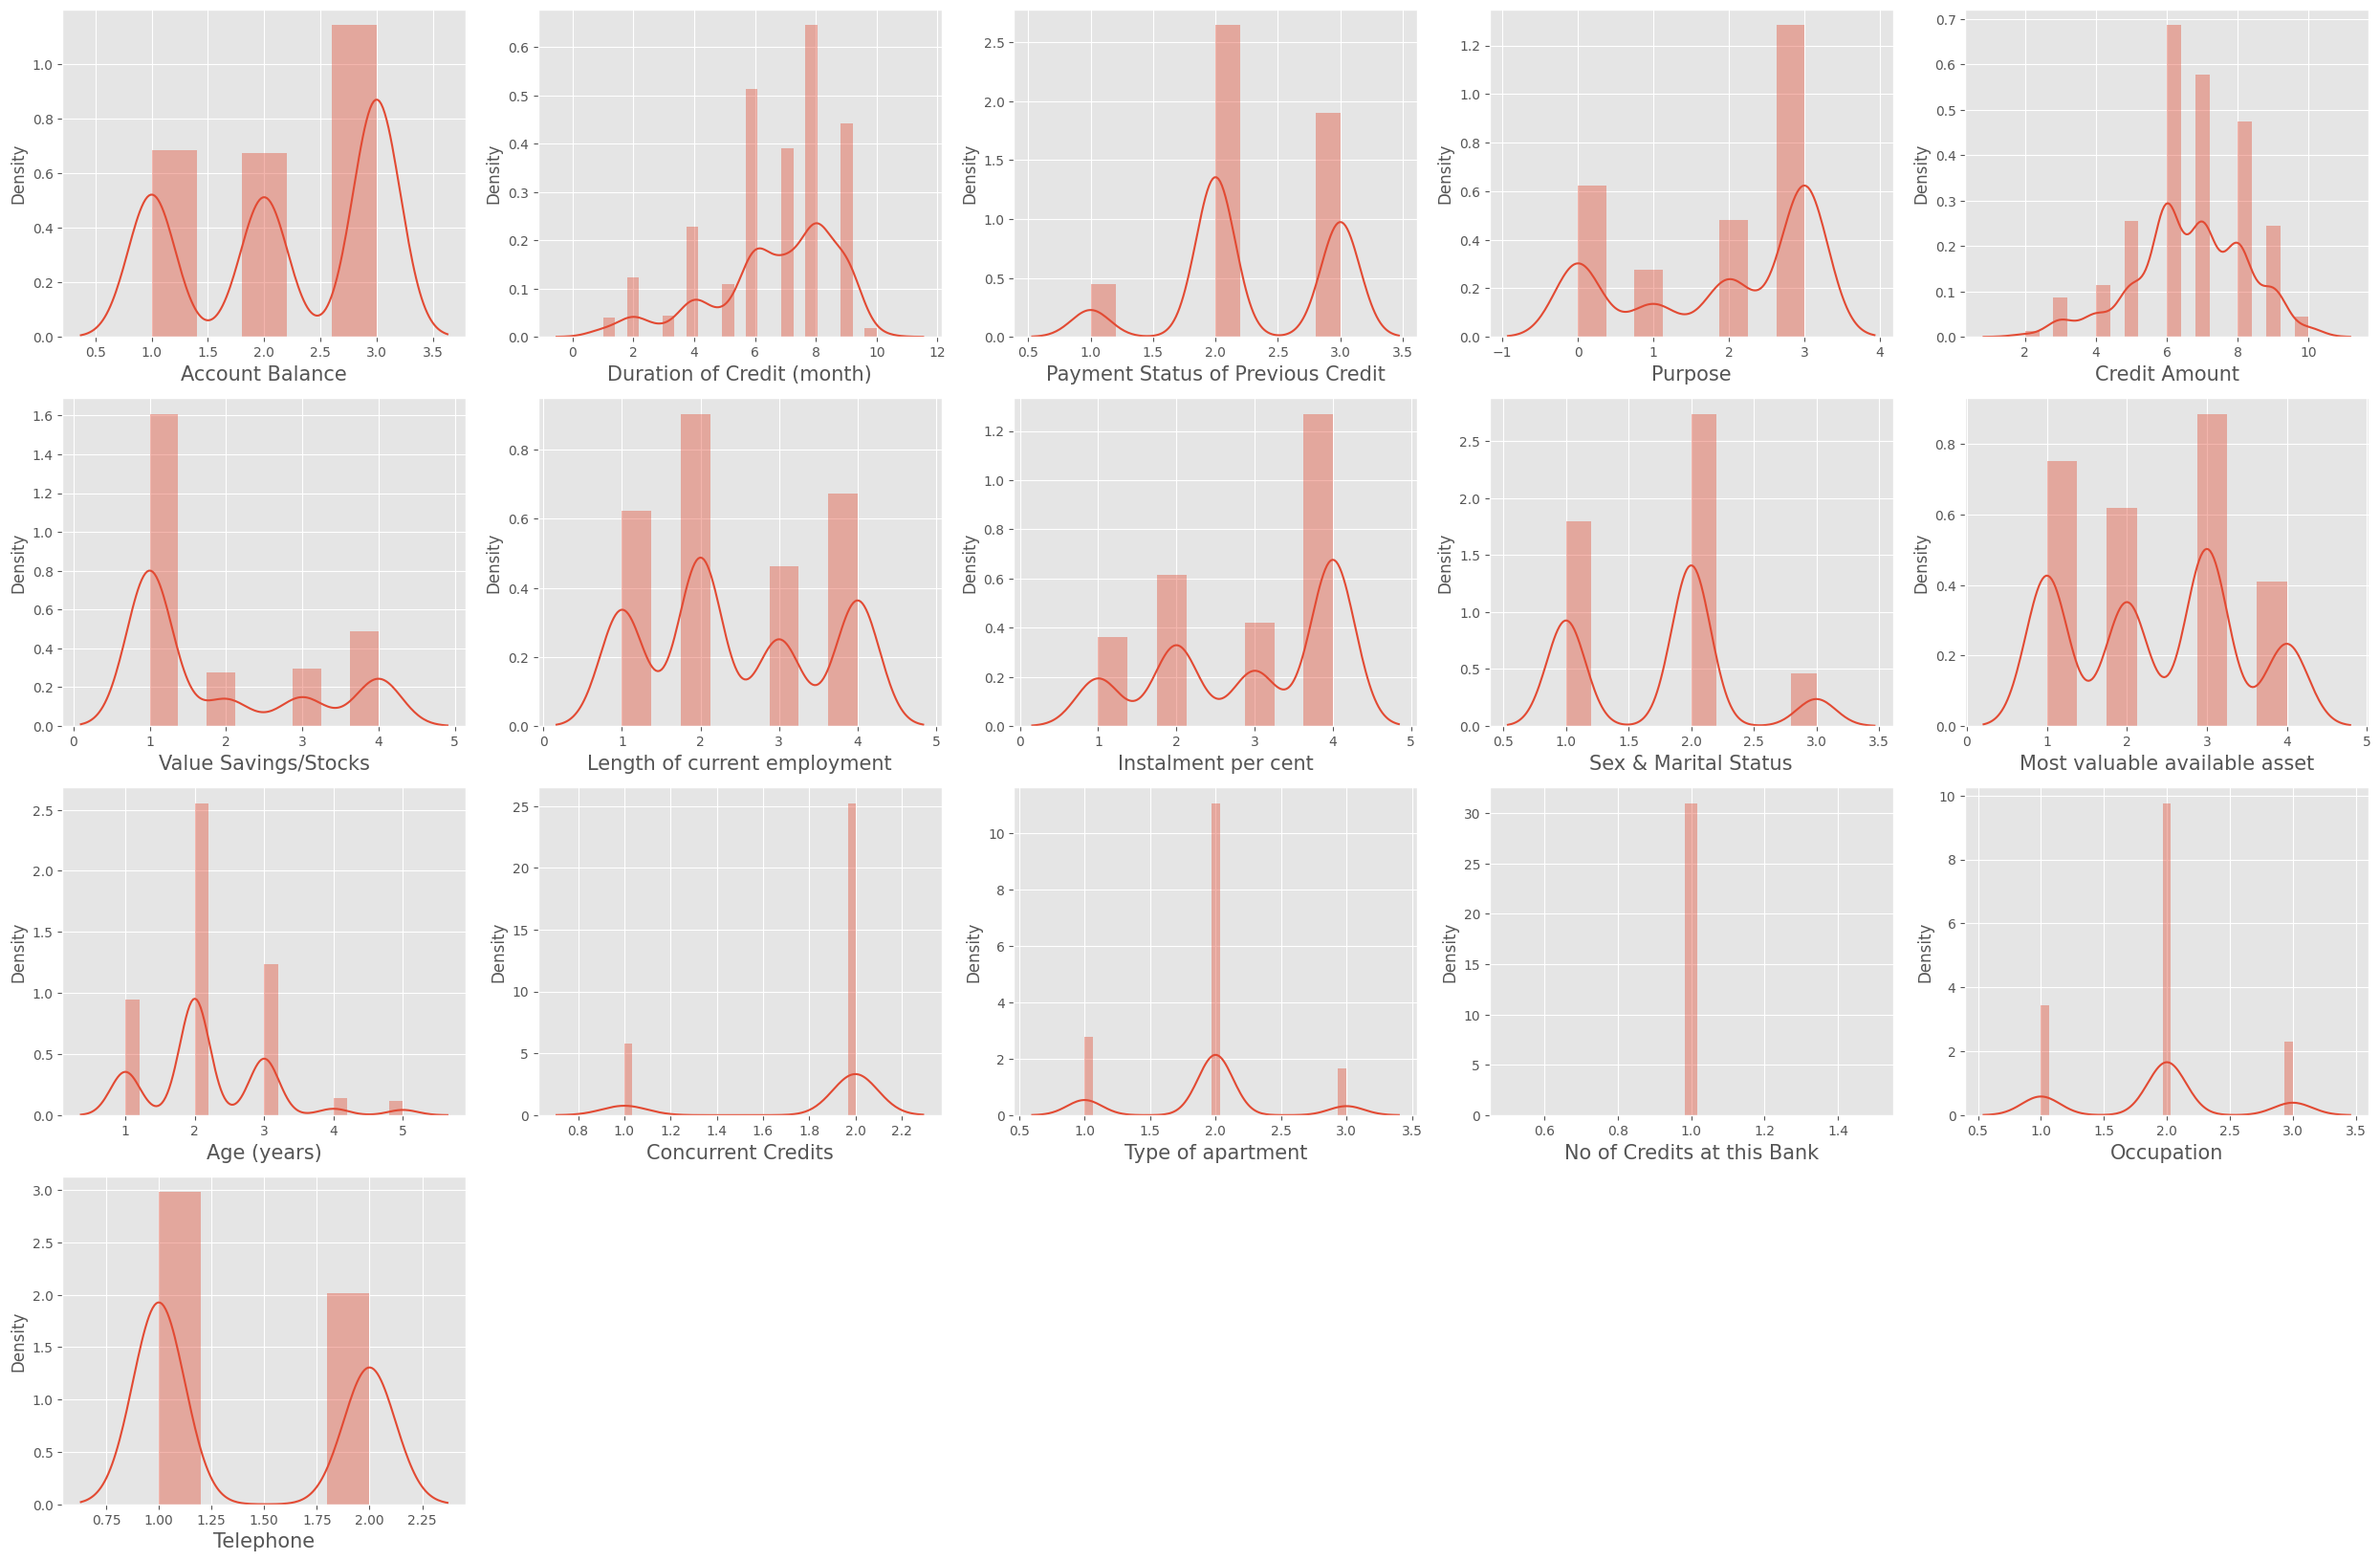

In [9]:
plt.figure(figsize=(25, 20))
plotnumber = 1
for col in X.columns:
    if plotnumber <= 24:
        ax = plt.subplot(5, 5, plotnumber)
        sns.distplot(X[col])
        plt.xlabel(col, fontsize=15)
    plotnumber += 1
plt.tight_layout()
plt.show()

## 4. Model Building and Training using XGBoost

### Initialize XGBoost Classifier

In [10]:
xgbc = XGBClassifier(n_estimators=120, use_label_encoder=False, eval_metric='logloss')

### Hyperparameter tuning with RandomizedSearchCV

In [11]:
param_dist = {
    'learning_rate': uniform(0.01, 0.1),
    'max_depth': randint(1, 10),
    'n_estimators': randint(10, 500),
    'gamma': uniform(0.01, 0.1),
    'subsample': uniform(0.1, 0.5),
    'colsample_bytree': uniform(0.1, 0.5)
}

xgbc_rscv = RandomizedSearchCV(
    estimator=xgbc,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

xgbc_rscv.fit(X_res, y_res)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28ef3fb80>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28ee4a130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x28e616eb0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28ef3f970>},
                   scoring='accuracy')

### Best parameters and best score

In [12]:
print('Best hyperparameters: ', xgbc_rscv.best_params_)
print('Best score: ', xgbc_rscv.best_score_)

Best hyperparameters:  {'colsample_bytree': 0.5396966692369856, 'gamma': 0.0471473812604383, 'learning_rate': 0.05975550022550723, 'max_depth': 9, 'n_estimators': 264, 'subsample': 0.5776674704320337}
Best score:  0.8164285714285715


### Retraining with best parameters

In [36]:
best_params = xgbc_rscv.best_params_
model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss')
model.fit(X_res, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5396966692369856, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=0.0471473812604383, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05975550022550723,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=264, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## 5. Model Evaluation

### K-Fold Cross-Validation

In [39]:
from sklearn.model_selection import StratifiedKFold, cross_val_score


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

print(f'K-Fold CV Accuracy: {accuracy.mean()} ± {accuracy.std()}')

f1 = cross_val_score(model, X, y, cv=kfold, scoring='f1')

print(f'K-Fold CV F1 Score: {f1.mean()} ± {f1.std()}')

auc = cross_val_score(model, X, y, cv=kfold, scoring='roc_auc')

print(f'K-Fold CV AUC: {auc.mean()} ± {auc.std()}')

recall = cross_val_score(model, X, y, cv=kfold, scoring='recall')

print(f'K-Fold CV Recall: {recall.mean()} ± {recall.std()}')

precision = cross_val_score(model, X, y, cv=kfold, scoring='precision')

print(f'K-Fold CV Precision: {precision.mean()} ± {precision.std()}')

K-Fold CV Accuracy: 0.764 ± 0.017146428199482262
K-Fold CV F1 Score: 0.8401393483541477 ± 0.010387674609648798
K-Fold CV AUC: 0.759047619047619 ± 0.03352386025429059
K-Fold CV Recall: 0.8857142857142858 ± 0.022587697572631286
K-Fold CV Precision: 0.7998501759366752 ± 0.021420815626104466


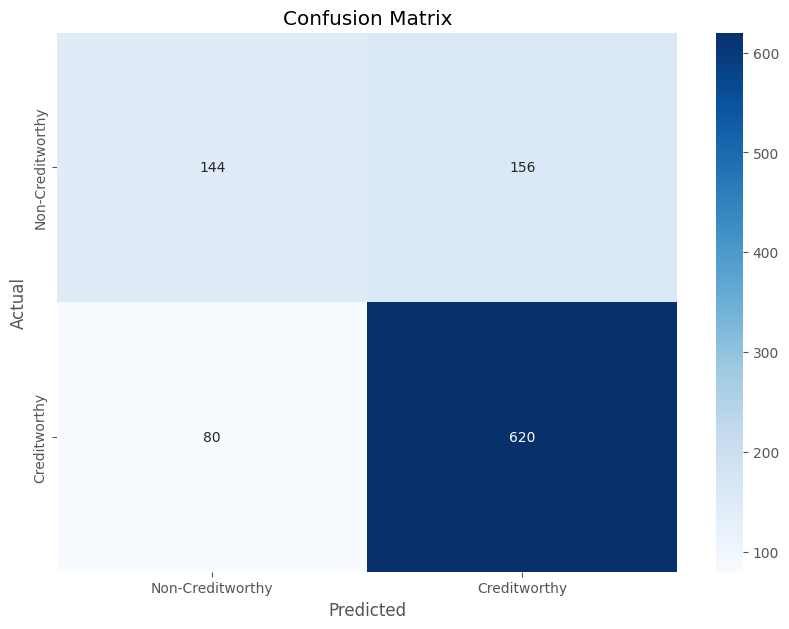

In [41]:
# Confusion Matrix after k-fold CV
y_true = []
y_pred = []

for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    y_true.extend(y_test)
    y_pred.extend(predictions)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Creditworthy', 'Creditworthy'], yticklabels=['Non-Creditworthy', 'Creditworthy'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()



### Create a dictionary with the results

In [ ]:
results = {
        'acc': accuracy.mean(),
        'precision': precision.mean(),
        'recal': recall.mean(),
        'f1': f1.mean(),
        'auc': auc.mean(),
        'confus matrix': cm.tolist()  # Convert numpy array to list for JSON serialization
    }

### Save result to a Json file

In [45]:
import json

with open('model_results.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)


## 6. Save Model

In [44]:
pickle.dump(model, open('xgboost_model.pkl', 'wb'))

## Load Model

In [18]:
# with open('xgboost_model.pkl', 'rb') as f:
#     xgbc_rscv_model = pickle.load(f)
# new_data = pd.DataFrame([[1, 1, 0, 0, 0, 360, 1, 0, 4.5, 8.2]], columns=['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'log_LoanAmount', 'log_TotalIncome'])
# predictions = xgbc_rscv_model.predict(new_data)
# print(predictions)